# <center><b>CNN for Alzheimer's Detection From MRI Images</b></center>

# INTRODUCTION
Alzheimer’s disease (AD) is a neurological disorder that results in diminished cognitive function. AD onset most often occurs when people are in their mid 60s and is the most frequent cause of dementia in seniors. It is currently estimated that over 6 million American’s over 65 have AD [4]. There are currently no cures for AD, however there are some treatment strategies. Early detection and intervention have been shown to slow disease progression and improve the quality of life for individuals suffering from AD [3]. Definitively diagnosing AD while someone is alive remains a challenge for the medical community and several metrics need to be assessed to determine if an individual is suffering from AD [2]. These methods may include brain scans such as magnetic resonance imaging (MRI), cognitive assessments through testing of memory, attention and problem solving, overall health assessment, and examining environmental and biological factors [2]. Developing models that help detect early-stage AD would be a great help to those suffering from the disease. The focus of this project will be to build a convolutional neural network (CNN) to detect AD in MRI scans. 

# LIBRARIES

In [1]:
import os
import glob
import numpy as np 
import pandas as pd 
import math
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.activations import leaky_relu
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

2025-09-28 19:57:18.215664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759089438.599041      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759089438.709519      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATA EXPLORATION AND PROCESSING
The dataset used for this project consists of images from MRI brain scans. The MRI technique is non-invasive and can produce detailed images of soft tissue such as brain tissue [1]. Changes in brain structure such as cerebral atrophy (shrinking of the brain), and abnormal protein build up are characteristics of AD [2]. The data is comprised of four classes, Non-Demented, Mild Demented, Moderate Demented, and Very Mild Demented. The data is preprocessed so little cleaning needs to be done. However, the images will still be normalized using a data generator. 

**Alzheimer MRI Preprocessed Dataset Available at Kaggle**
https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/data


## Directories

In [2]:
dataset_dir = "/kaggle/input/imagesoasis/Data" 

# Check if the directory exists 
if os.path.exists("/kaggle/input/imagesoasis"):
    print("Dataset directory exists")
    print("Contents:", os.listdir("/kaggle/input/imagesoasis"))
else:
    print("Dataset directory not found")
    print("Available inputs:", os.listdir("/kaggle/input"))

Dataset directory exists
Contents: ['Data']


### Check Categories

In [3]:
categories = os.listdir(dataset_dir)
print("Categories:", categories)

Categories: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


## Load the Data

**Check Number of Images per Category**

In [4]:
image_paths = []
labels = []

for class_idx, class_name in enumerate(categories):
    class_path = os.path.join(dataset_dir, class_name)
        
    # Get image files 
    files = glob.glob(os.path.join(class_path, "*.jpg"))
    if not files:
        files = glob.glob(os.path.join(class_path, "*.jpeg"))
    if not files:
        files = glob.glob(os.path.join(class_path, "*.png"))
    
    print(f"Category: {class_name}, Files found: {len(files)}")
    
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_idx)

print(f"Total images found: {len(image_paths)}")


Category: Non Demented, Files found: 67222
Category: Very mild Dementia, Files found: 13725
Category: Moderate Dementia, Files found: 488
Category: Mild Dementia, Files found: 5002
Total images found: 86437


## Oversampling minority classes with augmented copies. 


In [5]:
import shutil
import random
from tqdm import tqdm

### Define directory for oversampling and targets

In [6]:
original_dir = "/kaggle/input/imagesoasis/Data"
output_dir = "/kaggle/working/AugmentedData"

# Target sizes 
target_counts = {
    'Mild Dementia': 6000,
    'Moderate Dementia': 3000,
    'Very mild Dementia': 14000,
    'Non Demented': 67222  # most frequent, leave unchanged
}

### Create Data Augmentation Generator

In [7]:
augmenter = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

### Augment and Balance Dataset

In [8]:
img_size = (256, 256)

def augment_class_images(class_name):
    class_input_dir = os.path.join(original_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    # Copy original images
    original_images = os.listdir(class_input_dir)
    for fname in original_images:
        shutil.copy(os.path.join(class_input_dir, fname), os.path.join(class_output_dir, fname))

    # Count total images needed
    current_count = len(original_images)
    target_count = target_counts[class_name]

    print(f"Upsampled {class_name} from {current_count} to {target_count} images")

    if current_count >= target_count:
        print("No augmentation needed.")
        return

    augment_needed = target_count - current_count
    i = 0
    loop_idx = 0

    while i < augment_needed:
        img_name = original_images[loop_idx % current_count]
        img_path = os.path.join(class_input_dir, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        for batch in augmenter.flow(img_array, batch_size=1):
            new_fname = f"aug_{i}_{img_name}"
            array_to_img(batch[0]).save(os.path.join(class_output_dir, new_fname))
            i += 1
            break  # generate 1 image per iteration

        loop_idx += 1

In [9]:
for cls in target_counts:
    augment_class_images(cls)

Upsampled Mild Dementia from 5002 to 6000 images
Upsampled Moderate Dementia from 488 to 3000 images
Upsampled Very mild Dementia from 13725 to 14000 images
Upsampled Non Demented from 67222 to 67222 images
No augmentation needed.


## Downsampling of Majority Class, 'Non Demented'


In [10]:
def downsample_class(
    input_dir,
    output_dir,
    class_name='Non Demented',
    target_count=20000,
    seed=42
):
    """
    Randomly downsample images from input directory and copy them to a new folder.
    """
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    # List image files
    image_files = os.listdir(class_input_path)
    random.seed(seed)
    selected_files = random.sample(image_files, target_count)

    # Copy selected files
    for fname in selected_files:
        src = os.path.join(class_input_path, fname)
        dst = os.path.join(class_output_path, fname)
        shutil.copy(src, dst)

    print(f"Downsampled '{class_name}' from {len(image_files)} to {target_count} images.")

In [11]:
downsample_class(
    input_dir="/kaggle/input/imagesoasis/Data",
    output_dir="/kaggle/working/AugmentedData",
    class_name="Non Demented",
    target_count=20000  
)

Downsampled 'Non Demented' from 67222 to 20000 images.


## Data Generator
Normalize the pixel values of the images by dividing them by 255 ensuring that the pixel values are in the range [0, 1] instead of [0, 255]. Also, splits the data into testing and validation sets. 

In [12]:
# Create ImageDataGenerator objects
datagen = ImageDataGenerator(validation_split=0.20, rescale=1./255)

# Training data generator
train_generator = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256), # Resize images to 256x256 pixels
    batch_size=32,
    class_mode='categorical', # For multi-class classification
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256), # Resize images to 256x256 pixels
    batch_size=32,
    class_mode='categorical', # For multi-class classification
    subset='validation'
)

Found 72178 images belonging to 4 classes.
Found 18044 images belonging to 4 classes.


## Display Example Images

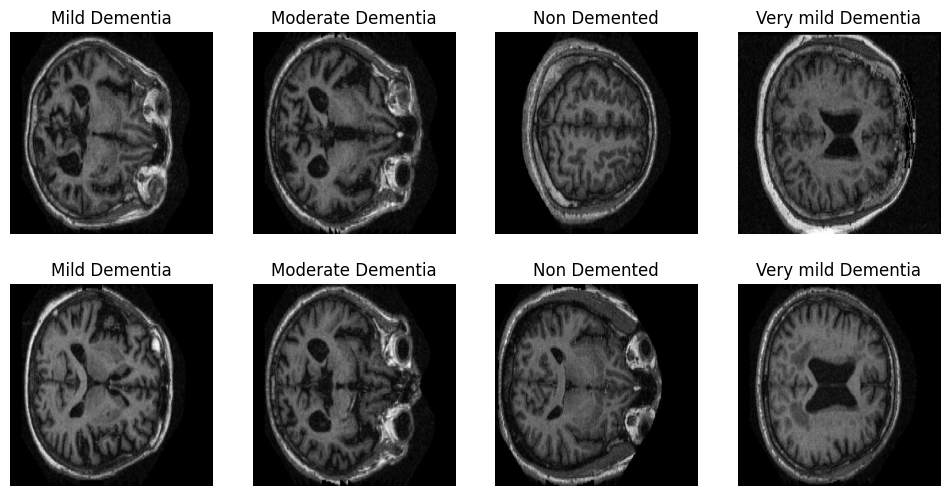

In [13]:
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

num_images_display = 2

# Initialize plot
fig, axes = plt.subplots(num_images_display, len(classes), figsize = (len(classes) * 3, num_images_display * 3))

# Loop to get images from each class
for i, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)[:num_images_display]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size =(256, 256))
        img_array = image.img_to_array(img)/ 255.0
        
        ax = axes[j,i]
        ax.imshow(img_array)
        ax.axis('off')
        ax.set_title(f"{class_name}")
        
plt.tight_layout
# Save image (optional)
#plt.savefig('example_mri.png')
plt.show()

# MODELS
CNNs will be used to detect AD in brain tissue by analyzing MRI images. CNNs are an appropriate choice for this task for several reasons. For one they use convolutional layers with local receptive fields to recognize patterns such as edges, textures and shape. Given the changes in brain structure associated with AD [2], detecting patterns such as these could be helpful in diagnosing the disease. CNNs process images through multiple layers, they learn to extract increasingly complex features. Early layers detect simple structures, while deeper layers can capture more complex patterns, such as those associated with cerebral atrophy and protein build-up. 

## Learning Rate Scheduler
This scheduler will be used to decrease the learning rate during model training. 

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', # assess validation loss
    factor = 0.5, # amount to reduce lr by
    patience = 2, # number of epochs to wait with no improvemnet 
    min_lr = 1e-6, # min lr not to go below
    verbose = 1 # print out when lr is reduce
)


### Performance Plot Function
Plots the accuracy, loss and auc scores from model training history.

In [15]:
def model_performance_plots(history, model_name):
    """
    Plot the accuracy, loss, and auc score from the training history.
    Inputs: 
    history - the history of the fit method of the model
    model_name - the name of the model
    """

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend(loc='upper right')

    # AUC Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(f'{model_name} AUC')
    plt.legend(loc='lower right')

    plt.tight_layout()


## Model Architecture

**Convolutional Layers:** capture spatial hierarchies in the data

Conv2D(64, (3, 3), padding='same', activation='leaky_relu', input_shape=(256, 256, 3)): The first convolutional layer with 64 filters of size 3x3, using ReLU activation, with padding to keep the dimensions the same as the input. The input shape is 256x256 with 3 channels (RGB).

Conv2D(128, (3, 3), activation='leaky_relu',padding='same'): The second convolutional layer with 128 filters. 

Conv2D(256, (3, 3), activation='leaky_relu',padding='same'): The third convolutional layer with 256 filters. 

Conv2D(512, (3, 3), activation='leaky_relu',padding='same'): The third convolutional layer with 512 filters. 

**Batch Normalization:**

Added after each convolutional layer to normalize the activations, stabilize the learning process, and potentially reduce overfitting.

**Max Pooling:**

MaxPooling2D((2, 2)) reduces the spatial dimensions by half, and helps the model focus on the most important features.

**GlobalAveragePooling:** 

GlobalAveragePooling before dense layers.

**Dense Layers:**

Dense(256): A fully connected layer with 256 units. Larger dense layer can learn more complex and abstract features from the data allowing the model to capture more detailed information and interactions.

Dense(4, activation='softmax'): The output layer with 4 units (since it’s a 4-class classification problem) and softmax activation to output class probabilities.


In [16]:
# Define input
inputs = Input(shape=(256, 256, 3))
x = inputs

x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation=leaky_relu, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation=leaky_relu, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), padding='same', activation=leaky_relu, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling to reduce spatial dimensions
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(256)(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# Output 
outputs = Dense(4, activation='softmax', kernel_regularizer=l2(0.001))(x)

# Build model
model = Model(inputs, outputs)

I0000 00:00:1759090371.954504      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759090371.955182      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'auc'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,688,196 (6.44 MB)

 Trainable params: 1,685,764 (6.43 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [18]:
# Fit model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    callbacks=[reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1759090380.019396      80 service.cc:148] XLA service 0x79e634017300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759090380.021055      80 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759090380.021078      80 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759090380.739867      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759090400.214022      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1481/2256 ━━━━━━━━━━━━━━━━━━━━ 2:20 182ms/step - accuracy: 0.6917 - auc: 0.8816 - loss: 1.3938

E0000 00:00:1759090674.711614      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759090674.958700      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2256/2256 ━━━━━━━━━━━━━━━━━━━━ 490s 206ms/step - accuracy: 0.7236 - auc: 0.9044 - loss: 1.3039 - val_accuracy: 0.3639 - val_auc: 0.6110 - val_loss: 2.4799 - learning_rate: 5.0000e-05
Epoch 2/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 444s 197ms/step - accuracy: 0.8670 - auc: 0.9804 - loss: 0.8409 - val_accuracy: 0.6364 - val_auc: 0.8339 - val_loss: 1.4626 - learning_rate: 5.0000e-05
Epoch 3/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 443s 196ms/step - accuracy: 0.9242 - auc: 0.9926 - loss: 0.6404 - val_accuracy: 0.1920 - val_auc: 0.3605 - val_loss: 3.4176 - learning_rate: 5.0000e-05
Epoch 4/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9584 - auc: 0.9974 - loss: 0.5007
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 443s 196ms/step - accuracy: 0.9584 - auc: 0.9974 - loss: 0.5007 - val_accuracy: 0.2842 - val_auc: 0.6080 - val_loss: 2.2589 - learning_rate: 5.0000e-05
Epoch 5/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 443s 197ms/step - accura

## Results

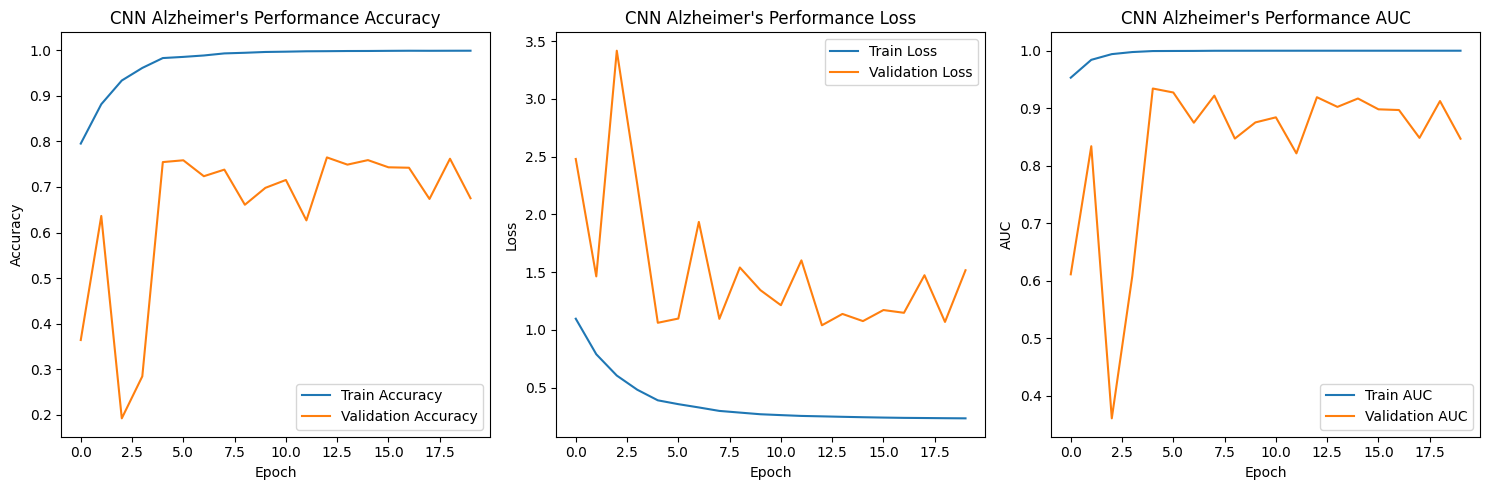

In [19]:
# Plot results
model_plots = model_performance_plots(history, "CNN Alzheimer's Performance")
plt.savefig("/kaggle/working/model_performance_plots.jpg")
plt.show()

### Confusion Matrix

In [20]:
# True labels from the validation generator
validation_labels = validation_generator.classes

# Predict the probabilities for the validation data
predictions = model.predict(validation_generator)

# Convert the probabilities to labels
predicted_classes = np.argmax(predictions, axis=1)

564/564 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step


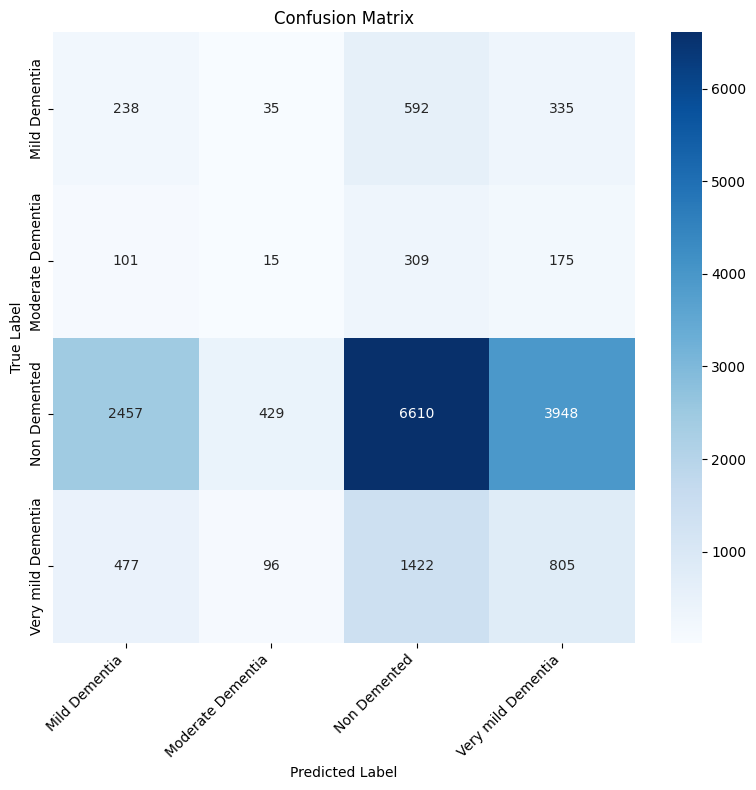

In [21]:
# Generate confusion matrix
conf_matrix = confusion_matrix(validation_labels, predicted_classes)

# Plot 
plt.figure(figsize=(8, 8), dpi=100)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("/kaggle/working/model_confusion_matrix.jpg")
plt.show()

# CONCLUSION
Adult dementia is devastating to the individuals inflicted and their loved ones. If current population trends continue, there will be a dramatic increase in the number of people suffering from AD [5]. Deep learning techniques such as CNN could be helpful in detecting early-stage AD and directing treatments to those afflicted sooner. 

**Improvements**

Dealing with overfitting while increasing accuracy needs to be addressed. One possible way to improve the model’s performance would be to apply transfer learning. Foster showed that using a pretrained MobileNetV2 architecture to detect AD in MRI images enhanced a deep learning model [3]. However, Foster was working on binary AD classification not a multi-class problem. 


# REFERENCES

[1] Ashby, K., Adams, B. N., & Shetty, M. (2022, November 14). Appropriate magnetic resonance imaging ordering. StatPearls - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK565857/

[2] Coupé, P., Manjón, J. V., Lanuza, E., & Catheline, G. (2019). Lifespan changes of the human brain in Alzheimer’s disease. Scientific Reports, 9(1). https://doi.org/10.1038/s41598-019-39809-8

[3] Foster, L. (2023, April 18). Identifying Alzheimer’s Disease with Deep Learning: A Transfer Learning Approach. Medium. https://medium.com/@lfoster49203/identifying-alzheimers-disease-with-deep-learning-a-transfer-learning-approach-620abf802631

[4] “How Is Alzheimer’s Disease Diagnosed?”. National Institute on Aging. Dec.08, 2022. https://www.nia.nih.gov/health/alzheimers-symptoms-and-diagnosis/how-alzheimers-disease-diagnosed

[5] Rasmussen, J., & Langerman, H. (2019). Alzheimer’s Disease – Why We Need Early    Diagnosis. Degenerative Neurological and Neuromuscular Disease, Volume 9, 123–130. https://doi.org/10.2147/dnnd.s228939

[6] “What Is Alzheimer’s Disease?”. National Institute on Aging, Jul. 08, 2021. https://www.nia.nih.gov/health/alzheimers-and-dementia/what-alzheimers-disease


Alzheimer MRI Preprocessed Dataset Available at Kaggle:
https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
